# Домашнее задание

В этом домашнем задании вам предстоит обучить DCGAN для генерации лиц и изучить латентное пространство. Модель DCGAN аналогична той, которая использовалась на лекции. Рекомендуем вам подробно ознакомится с приведенным кодом, чтобы лучше понимать как все устроено “изнутри”.


В качестве напоминания приводим ниже иллюстрацию архитектуры ([источник](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN) иллюстрации).

![alt text](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN/raw/master/tensorflow_DCGAN.png)

In [1]:
# ! pip install gdown

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import gdown
import time
import os
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imageio

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

In [2]:
class DCGAN(tf.keras.Model):
    def __init__(self, image_size, output_path, num_channels=1, z_dim=100,
                 G_h_size=128, D_h_size=128):
        """
        image_size -- размер стороны квадратной картинки
        output_path -- путь для сохранения артефактов обучения. в корне -- картинки с разных итераций, в папке model -- модель
        num_channels -- количество каналов изображения
        z_dim -- размерность латентного вектора
        G_h_size -- минимальный размер фильтров с сверточных слоях генератора
        D_h_size -- минимальный размер фильтров с сверточных слоях дискриминатора
        """
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.multiply = int(np.log2(self.image_size / 8)) # столько раз нужно применить апсемплинг или даунсемплинг
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2) и наоборот
                                                
        self.output_path =  Path(output_path)
        (self.output_path / "model").mkdir(exist_ok=True)

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer_d = tf.keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.999) # оптимизатор для дискриминатора
        self.optimizer_g = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)  # оптимизатор для генератора
         
        self.gen_loss_hist = []
        self.disc_loss_hist = []
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)
        self.start_iteration = 0

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        """
        Этот блок мы будем часто использовать -- поэтому вынесем его в отдельную функцию

        Он содержит Conv + BatchNorm + LeakyReLU

        При указании stride=2 -- уменьшит размер в два раза.
        """
        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model        

    def _build_generator(self):
        """
        Генератор должен превращать вектор длины self.z_dim в 
        картинку image_size x image_size x num_channels

        """
        
        model = tf.keras.Sequential()
        # для начала сделаем вектор -- трехмерным тензором м помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        # Превратим его в тензор размера (4, 4, self.G_h_size * 2**self.multiply)
        model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        
        for i in range(self.multiply):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 2**self.multiply // 2**(i+1))) # уменьшаем количество фильтров в два раза
        
        assert model.output_shape[1:] == (self.image_size // 2, self.image_size // 2, self.D_h_size), f"{model.output_shape, self.D_h_size}"
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        for i in range(self.multiply):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        assert model.output_shape[1:] == (4, 4, self.D_h_size * 2**self.multiply), f"{model.output_shape}"
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init, use_bias=False)) # без активации !
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        """
        Шаг обучения как в прошлом уроке
        """
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer_g.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer_d.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"{epoch}.png")
        plt.show()
    
    def train(self, dataset, num_iters=2000, show_every=25):
        """
        Цикл обучения
        """
        start = time.time()
        iters = self.start_iteration
        for image_batch in dataset:
            print(".", end='')
            gen_loss, disc_loss = self.train_step(image_batch)
            
            self.disc_loss_hist.append(disc_loss.numpy())
            self.gen_loss_hist.append(gen_loss.numpy())    
            
            if iters % show_every == 0:
                display.clear_output(wait=True)
                plt.figure()
                plt.plot(self.disc_loss_hist, label="Discriminator loss")
                plt.plot(self.gen_loss_hist, label="Generator loss")
                plt.legend(loc="best")
                plt.figure()
                self.save_imgs(f"{iters}")
                self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
                
                print(f"\n{iters}/{num_iters}")
                print(f'Time elapsed from start {time.time() - start} sec')
                
            iters += 1
            if iters > num_iters:
                print(f'Finished. Time elapsed from start {time.time() - start} sec')
                return

## Загрузка датасета

In [3]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz/'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

## Задание 1. Создание генераторов данных

Реализуйте генератор изображений с указанными ниже BATCH_SIZE и IMAGE_SIZE. Используйте для этого ImageDataGenerator, flow_from_dataframe или flow_from_directory. Данные расположены в папке "/tmp/UTKFace". Классы в этом задании нам не нужны.

*Интенсивности картинок должны быть нормализованы от -1 до 1.*

In [3]:
BATCH_SIZE = 100
IMAGE_SIZE = 64

In [4]:
os.listdir("/tmp/UTKFace/")

['54_0_0_20170120223243212.jpg.chip.jpg',
 '22_1_3_20170109132213417.jpg.chip.jpg',
 '37_0_0_20170119202407877.jpg.chip.jpg',
 '19_1_0_20170119145731470.jpg.chip.jpg',
 '30_1_0_20170117160402167.jpg.chip.jpg',
 '26_1_2_20170113000516258.jpg.chip.jpg',
 '27_1_3_20170117180032189.jpg.chip.jpg',
 '45_0_0_20170117203225383.jpg.chip.jpg',
 '34_0_1_20170113145505629.jpg.chip.jpg',
 '25_1_3_20170119172134400.jpg.chip.jpg',
 '32_1_1_20170113002108866.jpg.chip.jpg',
 '35_1_0_20170116222737439.jpg.chip.jpg',
 '27_1_4_20170103234931350.jpg.chip.jpg',
 '26_1_1_20170112212041107.jpg.chip.jpg',
 '58_0_0_20170120222516888.jpg.chip.jpg',
 '15_1_0_20170109213511851.jpg.chip.jpg',
 '31_0_1_20170117021212992.jpg.chip.jpg',
 '26_1_0_20170117174906552.jpg.chip.jpg',
 '33_0_3_20170117152711252.jpg.chip.jpg',
 '37_0_3_20170119202342181.jpg.chip.jpg',
 '32_1_2_20170116191408835.jpg.chip.jpg',
 '80_0_0_20170117175301125.jpg.chip.jpg',
 '42_0_1_20170113135655554.jpg.chip.jpg',
 '21_0_3_20170117141644440.jpg.chi

In [4]:
def create_image_generator(data, img_size, btch_size):
    
    # создаём список имён файлов
    data_folder = Path(data)
    filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
    
    # проверяем в цикле файлы на "работоспособность"   
    good = []
    bad = []

    for name in filenames:
        try:
            img = imageio.imread(data+name)
            good.append(name)
        except:
            bad.append(name)
            
    # создаём датафрейм
    data_df = {"img_name": good}
    df = pd.DataFrame(data_df)
                      
    train_datagen = ImageDataGenerator(preprocessing_function = lambda x: (x - 127.5)/127.5)
    
    image_generator = train_datagen.flow_from_dataframe(
    df, directory=data, x_col='img_name', target_size=(img_size, img_size), color_mode='rgb',
    classes=None, class_mode=None, batch_size=btch_size, shuffle=True,
    seed=None, save_to_dir=None, save_prefix='',
    save_format='jpg', subset=None, interpolation='bilinear',
    validate_filenames=True
    )
    
    return image_generator

In [ ]:
image_generator = create_image_generator(data="/tmp/UTKFace/", img_size=IMAGE_SIZE, btch_size=BATCH_SIZE)

Shape test passed


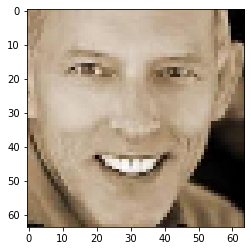

In [6]:
sample = next(image_generator)
assert sample.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), f"Размер батча должен быть: {(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)}.  Получен {sample.shape}"
print("Shape test passed")
# если препроцессинг правильный, то картинка ниже имеет реалистичные цвета и matplotlib не ругается
plt.imshow((sample[0] + 1.) / 2)
plt.show()

## Задание 2. Обучение DCGAN

В этом задании вам нужно просто запустить обучение GAN. С указанными параметрами оно займет около часа.

Предварительно замаунтите Google Drive, для сохранения промежуточных результатов и весов модели.

In [ ]:
# Для того, чтобы сохранять прогресс и веса модели, будем использовать google drive -- так модель не потеряется
# и в случае отключения Colab в сможете продолжить обучение.
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
output = Path("gan_utk_32")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan = DCGAN(image_size=IMAGE_SIZE, num_channels=3, output_path=output, 
           z_dim=256, D_h_size=128, G_h_size=128)

In [11]:
# если при запуске обучения вы видите "WARNING:tensorflow:Entity <bound method DCGAN.train_step ...", 
# раскомментируйте строчку ниже, установите пакет и рестартните runtime
# это временный баг в tf из-за изменения версии gast
#! pip install 'gast==0.2.2'

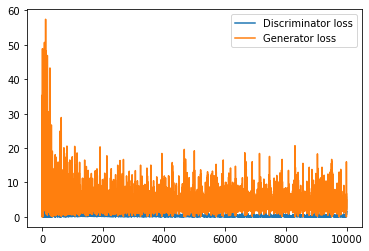

<Figure size 432x288 with 0 Axes>

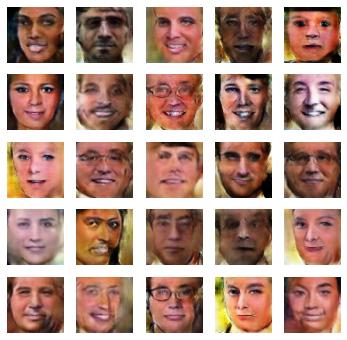


10000/10000
Time elapsed from start 5727.75750207901 sec
Finished. Time elapsed from start 5727.757517576218 sec


In [12]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

После того как модель обучена, можно посмотреть какие лица она научилась генерировать!

In [11]:
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нам нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [ 0.06237885 -0.0808178   1.4229187   0.5711494  -1.5188231   0.27013248
  0.23996632 -1.952119    0.37862122 -0.6820346 ]


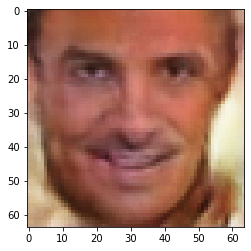

In [576]:
v1 = tf.random.normal([1, 256])                      # случайный вектор
print("Вектор: ", v1.numpy()[0, :10])                # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0])  # сгенерированное лицо, попробуйте сгенерировать несколько. 
                                                     # они должны получаться достаточно реалистичными

## Задание 3. Поиск вектора улыбки

В этом задании вам предстоит найти “вектор улыбки” и доказать что он таковым является. 

Что это означает? Как мы уже знаем, GAN генерирует данные из случайных векторов из определенного распределения. Такие вектора образуют латентное пространство. Напомню аналогию с бегунками в компьютерной игре - в этом случае латентное пространство задается всеми положениями бегунков, которым соответствуют реалистичные лица. 

В нашем случае GAN тоже выучил нечто подобное, ведь ему хватает 100 чисел, чтобы создать лицо -- это и есть его бегунки. Можно увидеть, что среди сгенерированных лиц имеются лица с улыбкой и без. А значит можно предположить, что какое-то определенное расположение этих бегунков (определенные значения латентного вектора) отвечают за улыбку. Тогда можно считать, что есть определенная комбинация этих 100 чисел, прибавив которую к вектору соответствующему нейтральному лицу можно получить это же лицо, только с улыбкой. Эти 100 чисел мы и называем “вектор улыбки”. 


In [7]:
def generate_many(generator, n):
    vis_noise = np.random.normal(0, 1, (n, 256)).astype(np.float32)
    gen_imgs = generator(vis_noise, training=False)
    show_many(gen_imgs, "Generated images")
    return vis_noise

def show_many(images, title=""):
    w = h = int(np.sqrt(len(images)))
    images = (np.clip(images, -1, 1) + 1.) / 2. 
    
    fig, axs = plt.subplots(w, h, figsize=(w, h))
    if title != "":
        fig.suptitle(title)

    cnt = 0
    for i in range(h):
        for j in range(w):
            axs[i, j].imshow(images[cnt, :, :, :])
            axs[i, j].set_title(f"{cnt}")
            axs[i, j].axis('off')
            cnt += 1
    plt.subplots_adjust(wspace=.5)

### a) Интерполяция
Используйте функцию show_interpolation для отображения превращения лица соответствующего латентному вектору `v_1` в лицо, соответствующее `v_2`. Вектора определите случайно из правильного распределения.



In [8]:
def show_interpolation(v_1, v_2, generator, n=20):
    """
    Превращает v_1 в v_2 за n шагов, изображая 
    картинки соответствующие промежуточным векторам
    
    """
    fig, axs = plt.subplots(1, n, figsize=(n,1))
    for i, alpha in enumerate(np.linspace(0, 1, n)):
        curr_vec = v_1 * (1-alpha) + v_2 * alpha
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')

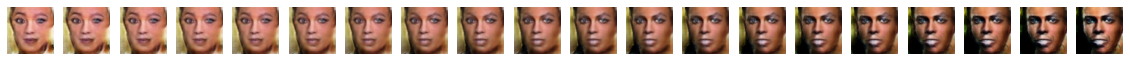

In [599]:
v1 = tf.random.normal([1, 256])
v2 = tf.random.normal([1, 256])

show_interpolation(v1, v2, gan.generator)

## b) Поиск вектора улыбки

Придумайте каким образом найти *вектор улыбки* в латентном пространстве и докажите визуально, что это именно он -- превратив нейтрального человека в улыбающегося и наоборот.

*Вам могут пригодится функции generate_many и show-interpolation*

Результат должен получиться похожим на:

<img alt="smile.png" src="https://sun9-51.userapi.com/c857228/v857228713/aea82/t93eL7L3zbU.jpg">  
Если затрудняетесь – ниже есть подсказка. Но обязательно сначала подумайте над задачей сами)

array([[ 4.6549264e-01, -2.3499051e-02,  6.1762249e-01, ...,
        -2.0409203e+00,  9.1654873e-01,  1.1577991e+00],
       [-9.9938941e-01, -5.5621141e-01,  2.6948602e+00, ...,
         6.5763152e-01, -6.0332465e-01,  8.6379844e-01],
       [-1.4983875e+00, -6.3939804e-01,  9.8800333e-03, ...,
        -1.2890841e+00,  2.1535911e-01, -1.3560442e+00],
       ...,
       [ 5.0322318e-01, -1.6942043e+00, -1.3077098e-03, ...,
         6.4085501e-01,  2.8093237e-01,  5.5663247e-02],
       [ 1.2358019e+00, -1.0781313e+00, -9.7744668e-01, ...,
         2.0566483e+00, -6.4347017e-01, -1.3153137e+00],
       [ 1.0689189e+00,  6.6419238e-01, -1.1865213e+00, ...,
        -9.5026815e-01,  8.5240871e-01,  1.4222348e+00]], dtype=float32)

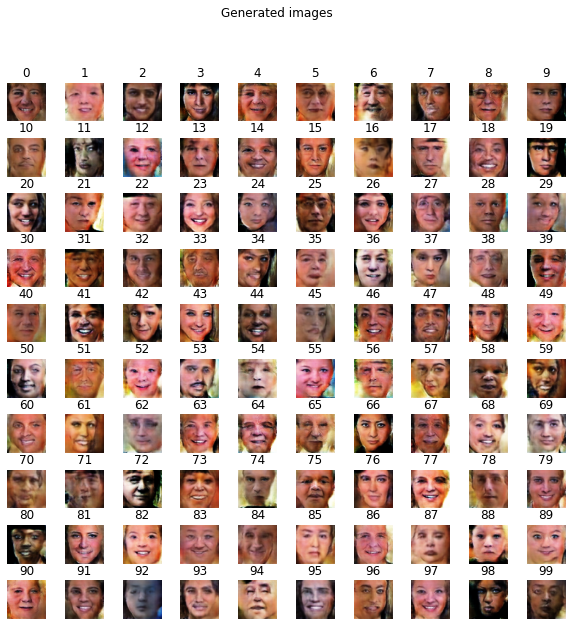

In [606]:
# поиск вектора улыбки
fs = generate_many(gan.generator, 100)
fs

In [609]:
# поиск вектора улыбки
mw = (fs[2]+fs[14]+fs[18]+fs[46]+fs[63]+fs[68]+fs[83]+fs[43]+fs[97]+fs[91])/10
mwo = (fs[5]+fs[70]+fs[13]+fs[10]+fs[99]+fs[78]+fs[58]+fs[19]+fs[54]+fs[51])/10
smile = mw - mwo

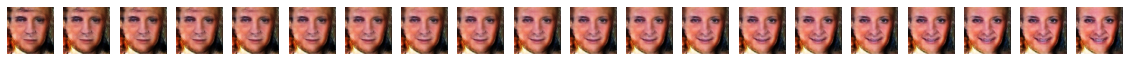

In [646]:
# нейтральный человек ------> с улыбкой
show_interpolation(fs[48], fs[48]+smile[None, ...], gan.generator)

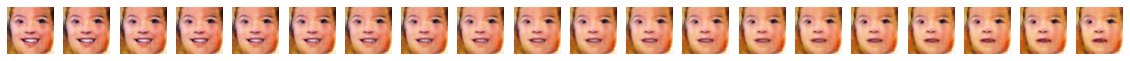

In [647]:
# человек с улыбкой ------> нейтральный
show_interpolation(fs[82], fs[82]-smile[None, ...], gan.generator)

## Бонусное задание

Есть несколько вариантов выполнения бонусного задания, оно необязательное, но поможет вам глубже погрузиться в тему:

1.  Как вы обратили внимание, мы работали с картинками очень маленького разрешения  -- 32x32. Это было сделано для ускорения вычислений. Попробуйте обучить модель 64x64. Это может занять гораздо больше времени. У авторов https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN на обучение ушло около 4 часов. Вы можете использовать датасет, [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) использованный ими. Или https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ .
2.  Проявите креатив. Обучите GAN для новых данных. Например, для генерации [мордочек кошек](https://ajolicoeur.wordpress.com/cats/) (по ссылке несколько практических рекомендаций по обучению GAN вообще и некоторые более новые архитектуры), [персонажей аниме](https://github.com/Mckinsey666/Anime-Face-Dataset) и тд. Вы можете изменять имеющийся код (делайте это ниже) или использовать сторонние реализации при обязательном цитировании источников.


**Обучим GAN на датасете Anime-Face-Dataset https://github.com/bchao1/Anime-Face-Dataset**

In [729]:
url = 'https://drive.google.com/u/0/uc?export=download&confirm=MdjG&id=1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI'
output = '/tmp/data.tgz/'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/data.tgz -C /tmp/

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=MdjG&id=1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI
To: /tmp/data.tgz
379MB [00:33, 11.3MB/s] 


In [762]:
os.listdir("/tmp/cropped/")

['37656_2012.jpg',
 '44909_2014.jpg',
 '764_2000.jpg',
 '61511_2018.jpg',
 '31994_2010.jpg',
 '55188_2016.jpg',
 '2960_2002.jpg',
 '25481_2009.jpg',
 '55192_2016.jpg',
 '50321_2015.jpg',
 '47507_2014.jpg',
 '16205_2006.jpg',
 '54776_2016.jpg',
 '10789_2005.jpg',
 '17877_2007.jpg',
 '27868_2009.jpg',
 '28572_2010.jpg',
 '51276_2015.jpg',
 '52807_2016.jpg',
 '17896_2007.jpg',
 '51558_2015.jpg',
 '25546_2009.jpg',
 '17816_2007.jpg',
 '33026_2011.jpg',
 '15872_2006.jpg',
 '54517_2016.jpg',
 '22153_2008.jpg',
 '5345_2003.jpg',
 '61345_2018.jpg',
 '30542_2010.jpg',
 '44411_2013.jpg',
 '19104_2007.jpg',
 '2982_2002.jpg',
 '22550_2008.jpg',
 '16437_2006.jpg',
 '22641_2008.jpg',
 '27886_2009.jpg',
 '4584_2003.jpg',
 '907_2000.jpg',
 '59230_2018.jpg',
 '34630_2011.jpg',
 '21998_2008.jpg',
 '14424_2006.jpg',
 '56685_2017.jpg',
 '51522_2015.jpg',
 '49283_2015.jpg',
 '35686_2011.jpg',
 '41233_2013.jpg',
 '2002_2001.jpg',
 '56481_2017.jpg',
 '24423_2008.jpg',
 '11286_2005.jpg',
 '34294_2011.jpg',
 '

In [766]:
image_generator = create_image_generator(data="/tmp/cropped/", img_size=IMAGE_SIZE, btch_size=BATCH_SIZE)

Found 63569 validated image filenames.


Shape test passed


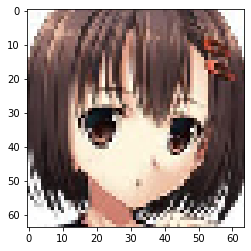

In [767]:
sample = next(image_generator)
assert sample.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), f"Размер батча должен быть: {(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)}.  Получен {sample.shape}"
print("Shape test passed")
# если препроцессинг правильный, то картинка ниже имеет реалистичные цвета и matplotlib не ругается
plt.imshow((sample[0] + 1.) / 2)
plt.show()

In [739]:
output = Path("anime")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan2 = DCGAN(image_size=IMAGE_SIZE, num_channels=3, output_path=output, 
           z_dim=256, D_h_size=128, G_h_size=128)

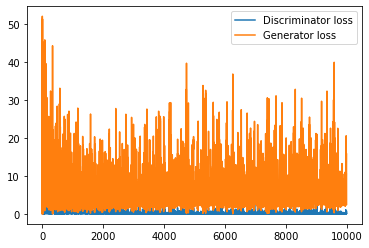

<Figure size 432x288 with 0 Axes>

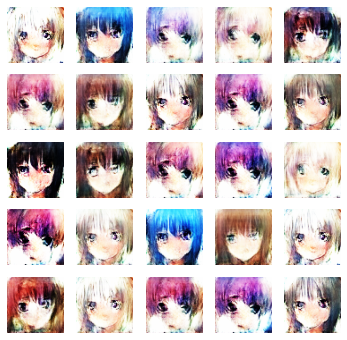


10000/10000
Time elapsed from start 5444.546537399292 sec
Finished. Time elapsed from start 5444.546550989151 sec


In [740]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan2.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan2.train(image_generator, 10000, 50)

Вектор:  [-1.0259537   0.11091045 -0.1791276   1.9357948  -0.46123254  1.5095245
 -1.4802538   1.5665303  -0.46499032 -0.2739933 ]


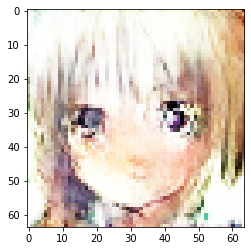

In [779]:
v1 = tf.random.normal([1, 256])                       # случайный вектор
print("Вектор: ", v1.numpy()[0, :10])                 # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan2.generator)[0])

**Обучим GAN на датасете CatDatabase https://web.archive.org/web/20150703060412/http://137.189.35.203/WebUI/CatDatabase/catData.html**

In [783]:
url = 'https://web.archive.org/web/20150703060412/http://137.189.35.203/WebUI/CatDatabase/Data/CAT_DATASET_01.zip'
output = '/tmp/CAT_DATASET_01.zip'
gdown.download(url, output, quiet=False)
# ! tar -xzf /tmp/CAT_DATASET_01.zip -C /tmp/

Downloading...
From: https://web.archive.org/web/20150703060412/http://137.189.35.203/WebUI/CatDatabase/Data/CAT_DATASET_01.zip
To: /tmp/CAT_DATASET_01.zip

0.00B [00:00, ?B/s]
32.8kB [00:00, 163kB/s]
98.3kB [00:00, 254kB/s]
229kB [00:00, 429kB/s] 
295kB [00:00, 375kB/s]
686kB [00:01, 934kB/s]
817kB [00:01, 804kB/s]
948kB [00:01, 778kB/s]
1.21MB [00:01, 911kB/s]
1.34MB [00:01, 826kB/s]
1.54MB [00:02, 855kB/s]
1.67MB [00:02, 782kB/s]
1.83MB [00:02, 783kB/s]
1.96MB [00:02, 735kB/s]
2.09MB [00:02, 701kB/s]
2.23MB [00:03, 674kB/s]
2.36MB [00:03, 661kB/s]
2.49MB [00:03, 654kB/s]
2.55MB [00:03, 586kB/s]
2.68MB [00:03, 691kB/s]
2.82MB [00:03, 757kB/s]
2.95MB [00:04, 523kB/s]
3.14MB [00:04, 659kB/s]
3.27MB [00:04, 631kB/s]
3.41MB [00:05, 505kB/s]
3.54MB [00:05, 536kB/s]
3.60MB [00:05, 483kB/s]
3.67MB [00:05, 446kB/s]
3.73MB [00:06, 415kB/s]
3.83MB [00:06, 430kB/s]
3.90MB [00:06, 405kB/s]
4.03MB [00:06, 449kB/s]
4.09MB [00:06, 413kB/s]
4.22MB [00:07, 463kB/s]
4.29MB [00:07, 433kB/s]
4.36MB [00:

43.0MB [02:28, 187kB/s]
43.1MB [02:29, 175kB/s]
43.1MB [02:29, 176kB/s]
43.2MB [02:30, 170kB/s]
43.3MB [02:30, 178kB/s]
43.3MB [02:30, 174kB/s]
43.4MB [02:31, 158kB/s]
43.4MB [02:31, 157kB/s]
43.5MB [02:32, 158kB/s]
43.6MB [02:32, 158kB/s]
43.6MB [02:32, 159kB/s]
43.7MB [02:33, 159kB/s]
43.8MB [02:33, 161kB/s]
43.8MB [02:34, 170kB/s]
43.9MB [02:34, 167kB/s]
44.0MB [02:34, 163kB/s]
44.0MB [02:35, 162kB/s]
44.1MB [02:35, 161kB/s]
44.2MB [02:36, 162kB/s]
44.2MB [02:36, 168kB/s]
44.3MB [02:36, 175kB/s]
44.4MB [02:37, 155kB/s]
44.4MB [02:37, 137kB/s]
44.5MB [02:38, 122kB/s]
44.6MB [02:39, 115kB/s]
44.6MB [02:39, 113kB/s]
44.7MB [02:40, 116kB/s]
44.8MB [02:41, 110kB/s]
44.8MB [02:41, 114kB/s]
44.9MB [02:42, 119kB/s]
45.0MB [02:42, 122kB/s]
45.0MB [02:43, 129kB/s]
45.1MB [02:43, 130kB/s]
45.2MB [02:44, 130kB/s]
45.2MB [02:44, 135kB/s]
45.3MB [02:44, 142kB/s]
45.3MB [02:45, 146kB/s]
45.4MB [02:45, 151kB/s]
45.5MB [02:46, 153kB/s]
45.5MB [02:46, 168kB/s]
45.6MB [02:46, 176kB/s]
45.7MB [02:47, 1

87.9MB [05:20, 411kB/s]
88.0MB [05:21, 407kB/s]
88.1MB [05:21, 379kB/s]
88.1MB [05:21, 392kB/s]
88.2MB [05:21, 410kB/s]
88.3MB [05:21, 314kB/s]
88.4MB [05:22, 384kB/s]
88.5MB [05:22, 364kB/s]
88.5MB [05:22, 351kB/s]
88.6MB [05:22, 343kB/s]
88.7MB [05:22, 336kB/s]
88.7MB [05:23, 354kB/s]
88.8MB [05:23, 345kB/s]
88.9MB [05:23, 339kB/s]
88.9MB [05:23, 381kB/s]
89.0MB [05:23, 400kB/s]
89.1MB [05:24, 375kB/s]
89.1MB [05:24, 387kB/s]
89.2MB [05:24, 367kB/s]
89.3MB [05:24, 400kB/s]
89.3MB [05:24, 420kB/s]
89.4MB [05:24, 388kB/s]
89.5MB [05:25, 397kB/s]
89.5MB [05:25, 374kB/s]
89.6MB [05:25, 428kB/s]
89.7MB [05:25, 417kB/s]
89.7MB [05:25, 390kB/s]
89.8MB [05:25, 395kB/s]
89.8MB [05:26, 380kB/s]
89.9MB [05:26, 422kB/s]
90.0MB [05:26, 413kB/s]
90.0MB [05:26, 389kB/s]
90.1MB [05:26, 394kB/s]
90.2MB [05:26, 383kB/s]
90.2MB [05:26, 422kB/s]
90.3MB [05:27, 414kB/s]
90.4MB [05:27, 416kB/s]
90.4MB [05:27, 391kB/s]
90.5MB [05:27, 426kB/s]
90.6MB [05:27, 432kB/s]
90.6MB [05:27, 428kB/s]
90.7MB [05:28, 4

133MB [07:47, 215kB/s]
133MB [07:48, 266kB/s]
133MB [07:48, 262kB/s]
133MB [07:48, 273kB/s]
133MB [07:49, 256kB/s]
133MB [07:49, 270kB/s]
133MB [07:49, 266kB/s]
133MB [07:49, 276kB/s]
134MB [07:50, 287kB/s]
134MB [07:50, 280kB/s]
134MB [07:50, 290kB/s]
134MB [07:50, 279kB/s]
134MB [07:51, 259kB/s]
134MB [07:51, 254kB/s]
134MB [07:51, 268kB/s]
134MB [07:51, 253kB/s]
134MB [07:52, 254kB/s]
134MB [07:52, 269kB/s]
134MB [07:52, 248kB/s]
134MB [07:52, 264kB/s]
134MB [07:53, 241kB/s]
134MB [07:53, 238kB/s]
134MB [07:53, 231kB/s]
135MB [07:53, 237kB/s]
135MB [07:54, 242kB/s]
135MB [07:54, 233kB/s]
135MB [07:54, 245kB/s]
135MB [07:54, 252kB/s]
135MB [07:55, 245kB/s]
135MB [07:55, 238kB/s]
135MB [07:55, 247kB/s]
135MB [07:56, 246kB/s]
135MB [07:56, 241kB/s]
135MB [07:56, 249kB/s]
135MB [07:56, 261kB/s]
135MB [07:57, 272kB/s]
135MB [07:57, 265kB/s]
135MB [07:57, 273kB/s]
135MB [07:57, 283kB/s]
136MB [07:58, 269kB/s]
136MB [07:58, 283kB/s]
136MB [07:58, 303kB/s]
136MB [07:58, 325kB/s]
136MB [07:5

181MB [10:15, 885kB/s] 
181MB [10:15, 1.38MB/s]
181MB [10:15, 1.22MB/s]
181MB [10:16, 1.21MB/s]
182MB [10:16, 1.16MB/s]
182MB [10:16, 1.18MB/s]
182MB [10:16, 928kB/s] 
182MB [10:16, 1.16MB/s]
182MB [10:17, 1.01MB/s]
182MB [10:17, 994kB/s] 
183MB [10:17, 959kB/s]
183MB [10:17, 955kB/s]
183MB [10:17, 934kB/s]
183MB [10:17, 915kB/s]
183MB [10:17, 777kB/s]
183MB [10:18, 730kB/s]
183MB [10:18, 772kB/s]
184MB [10:18, 670kB/s]
184MB [10:18, 595kB/s]
184MB [10:19, 580kB/s]
184MB [10:19, 558kB/s]
184MB [10:19, 543kB/s]
184MB [10:19, 532kB/s]
184MB [10:19, 551kB/s]
184MB [10:19, 556kB/s]
184MB [10:19, 527kB/s]
184MB [10:20, 387kB/s]
184MB [10:20, 539kB/s]
185MB [10:20, 398kB/s]
185MB [10:20, 406kB/s]
185MB [10:21, 383kB/s]
185MB [10:21, 363kB/s]
185MB [10:21, 326kB/s]
185MB [10:21, 324kB/s]
185MB [10:22, 323kB/s]
185MB [10:22, 322kB/s]
185MB [10:22, 326kB/s]
185MB [10:22, 345kB/s]
185MB [10:22, 337kB/s]
185MB [10:23, 252kB/s]
185MB [10:23, 328kB/s]
185MB [10:23, 319kB/s]
185MB [10:23, 301kB/s]
1

236MB [12:56, 295kB/s]
236MB [12:56, 290kB/s]
236MB [12:56, 296kB/s]
236MB [12:57, 302kB/s]
237MB [12:57, 301kB/s]
237MB [12:57, 306kB/s]
237MB [12:57, 330kB/s]
237MB [12:57, 361kB/s]
237MB [12:58, 348kB/s]
237MB [12:58, 340kB/s]
237MB [12:58, 284kB/s]
237MB [12:58, 301kB/s]
237MB [12:59, 290kB/s]
237MB [12:59, 296kB/s]
237MB [12:59, 301kB/s]
237MB [12:59, 306kB/s]
237MB [13:00, 310kB/s]
237MB [13:00, 314kB/s]
238MB [13:00, 337kB/s]
238MB [13:00, 332kB/s]
238MB [13:00, 381kB/s]
238MB [13:00, 365kB/s]
238MB [13:01, 351kB/s]
238MB [13:01, 342kB/s]
238MB [13:01, 343kB/s]
238MB [13:01, 335kB/s]
238MB [13:01, 345kB/s]
238MB [13:02, 338kB/s]
238MB [13:02, 361kB/s]
238MB [13:02, 374kB/s]
238MB [13:02, 386kB/s]
238MB [13:02, 314kB/s]
238MB [13:03, 316kB/s]
239MB [13:03, 292kB/s]
239MB [13:03, 287kB/s]
239MB [13:03, 292kB/s]
239MB [13:04, 298kB/s]
239MB [13:04, 305kB/s]
239MB [13:04, 314kB/s]
239MB [13:04, 316kB/s]
239MB [13:04, 289kB/s]
239MB [13:04, 347kB/s]
239MB [13:05, 364kB/s]
239MB [13:0

288MB [15:39, 132kB/s]
288MB [15:40, 139kB/s]
288MB [15:40, 142kB/s]
289MB [15:41, 143kB/s]
289MB [15:41, 148kB/s]
289MB [15:42, 151kB/s]
289MB [15:42, 153kB/s]
289MB [15:42, 155kB/s]
289MB [15:43, 154kB/s]
289MB [15:43, 156kB/s]
289MB [15:44, 156kB/s]
289MB [15:44, 170kB/s]
289MB [15:44, 180kB/s]
289MB [15:44, 202kB/s]
289MB [15:45, 196kB/s]
289MB [15:45, 217kB/s]
289MB [15:45, 239kB/s]
289MB [15:45, 259kB/s]
290MB [15:46, 282kB/s]
290MB [15:46, 326kB/s]
290MB [15:46, 366kB/s]
290MB [15:46, 364kB/s]
290MB [15:46, 366kB/s]
290MB [15:46, 436kB/s]
290MB [15:47, 475kB/s]
290MB [15:47, 502kB/s]
290MB [15:47, 552kB/s]
290MB [15:47, 583kB/s]
290MB [15:47, 606kB/s]
291MB [15:47, 673kB/s]
291MB [15:48, 764kB/s]
291MB [15:48, 622kB/s]
291MB [15:48, 831kB/s]
291MB [15:48, 767kB/s]
291MB [15:48, 733kB/s]
291MB [15:49, 710kB/s]
292MB [15:49, 688kB/s]
292MB [15:49, 691kB/s]
292MB [15:49, 782kB/s]
292MB [15:49, 618kB/s]
292MB [15:50, 726kB/s]
292MB [15:50, 534kB/s]
292MB [15:50, 638kB/s]
293MB [15:5

340MB [18:07, 254kB/s]
340MB [18:07, 258kB/s]
340MB [18:08, 260kB/s]
340MB [18:08, 272kB/s]
340MB [18:08, 272kB/s]
340MB [18:08, 257kB/s]
340MB [18:09, 247kB/s]
341MB [18:09, 263kB/s]
341MB [18:09, 277kB/s]
341MB [18:09, 277kB/s]
341MB [18:10, 261kB/s]
341MB [18:10, 273kB/s]
341MB [18:10, 261kB/s]
341MB [18:10, 275kB/s]
341MB [18:11, 286kB/s]
341MB [18:11, 294kB/s]
341MB [18:11, 300kB/s]
341MB [18:11, 307kB/s]
341MB [18:11, 311kB/s]
341MB [18:12, 328kB/s]
341MB [18:12, 375kB/s]
341MB [18:12, 388kB/s]
342MB [18:12, 381kB/s]
342MB [18:12, 365kB/s]
342MB [18:12, 446kB/s]
342MB [18:13, 412kB/s]
342MB [18:13, 474kB/s]
342MB [18:13, 521kB/s]
342MB [18:13, 531kB/s]
342MB [18:13, 567kB/s]
342MB [18:14, 630kB/s]
342MB [18:14, 601kB/s]
343MB [18:14, 657kB/s]
343MB [18:14, 773kB/s]
343MB [18:14, 751kB/s]
343MB [18:14, 718kB/s]
343MB [18:14, 822kB/s]
343MB [18:15, 914kB/s]
343MB [18:15, 628kB/s]
344MB [18:15, 756kB/s]
344MB [18:15, 888kB/s]
344MB [18:16, 764kB/s]
344MB [18:16, 721kB/s]
344MB [18:1

389MB [20:31, 825kB/s]
389MB [20:31, 767kB/s]
389MB [20:32, 570kB/s]
389MB [20:32, 551kB/s]
389MB [20:32, 550kB/s]
389MB [20:33, 492kB/s]
389MB [20:33, 472kB/s]
389MB [20:33, 459kB/s]
389MB [20:33, 417kB/s]
390MB [20:33, 406kB/s]
390MB [20:34, 362kB/s]
390MB [20:34, 350kB/s]
390MB [20:34, 303kB/s]
390MB [20:34, 306kB/s]
390MB [20:35, 241kB/s]
390MB [20:35, 294kB/s]
390MB [20:35, 260kB/s]
390MB [20:36, 263kB/s]
390MB [20:36, 253kB/s]
390MB [20:36, 252kB/s]
390MB [20:37, 242kB/s]
390MB [20:37, 258kB/s]
390MB [20:37, 225kB/s]
390MB [20:37, 241kB/s]
391MB [20:38, 258kB/s]
391MB [20:38, 250kB/s]
391MB [20:38, 236kB/s]
391MB [20:38, 255kB/s]
391MB [20:39, 265kB/s]
391MB [20:39, 254kB/s]
391MB [20:39, 270kB/s]
391MB [20:39, 270kB/s]
391MB [20:40, 261kB/s]
391MB [20:40, 275kB/s]
391MB [20:40, 285kB/s]
391MB [20:40, 294kB/s]
391MB [20:40, 299kB/s]
391MB [20:41, 304kB/s]
391MB [20:41, 309kB/s]
392MB [20:41, 349kB/s]
392MB [20:41, 360kB/s]
392MB [20:41, 384kB/s]
392MB [20:41, 376kB/s]
392MB [20:4

450MB [22:32, 300kB/s]
450MB [22:32, 317kB/s]
450MB [22:32, 339kB/s]
450MB [22:32, 371kB/s]
450MB [22:32, 376kB/s]
450MB [22:32, 370kB/s]
450MB [22:33, 389kB/s]
450MB [22:33, 431kB/s]
450MB [22:33, 433kB/s]
450MB [22:33, 457kB/s]
450MB [22:33, 502kB/s]
450MB [22:33, 503kB/s]
450MB [22:33, 530kB/s]
451MB [22:33, 538kB/s]
451MB [22:34, 583kB/s]
451MB [22:34, 623kB/s]
451MB [22:34, 655kB/s]
451MB [22:34, 518kB/s]
451MB [22:34, 764kB/s]
451MB [22:35, 649kB/s]
451MB [22:35, 643kB/s]
452MB [22:35, 642kB/s]
452MB [22:35, 641kB/s]
452MB [22:35, 702kB/s]
452MB [22:36, 691kB/s]
452MB [22:36, 542kB/s]
452MB [22:36, 663kB/s]
452MB [22:36, 642kB/s]
453MB [22:37, 603kB/s]
453MB [22:37, 572kB/s]
453MB [22:37, 581kB/s]
453MB [22:37, 572kB/s]
453MB [22:37, 609kB/s]
453MB [22:37, 570kB/s]
453MB [22:38, 581kB/s]
453MB [22:38, 580kB/s]
453MB [22:38, 593kB/s]
453MB [22:38, 591kB/s]
454MB [22:38, 602kB/s]
454MB [22:38, 609kB/s]
454MB [22:39, 569kB/s]
454MB [22:39, 589kB/s]
454MB [22:39, 603kB/s]
454MB [22:3

504MB [24:48, 559kB/s]
504MB [24:48, 540kB/s]
504MB [24:49, 426kB/s]
505MB [24:49, 530kB/s]
505MB [24:49, 504kB/s]
505MB [24:49, 452kB/s]
505MB [24:49, 488kB/s]
505MB [24:49, 453kB/s]
505MB [24:50, 458kB/s]
505MB [24:50, 496kB/s]
505MB [24:50, 455kB/s]
505MB [24:50, 468kB/s]
505MB [24:50, 505kB/s]
505MB [24:50, 479kB/s]
505MB [24:50, 502kB/s]
505MB [24:51, 511kB/s]
506MB [24:51, 517kB/s]
506MB [24:51, 510kB/s]
506MB [24:51, 535kB/s]
506MB [24:51, 529kB/s]
506MB [24:51, 544kB/s]
506MB [24:51, 561kB/s]
506MB [24:52, 551kB/s]
506MB [24:52, 520kB/s]
506MB [24:52, 513kB/s]
506MB [24:52, 515kB/s]
506MB [24:52, 559kB/s]
506MB [24:52, 558kB/s]
506MB [24:52, 523kB/s]
507MB [24:53, 448kB/s]
507MB [24:53, 541kB/s]
507MB [24:53, 502kB/s]
507MB [24:53, 472kB/s]
507MB [24:53, 474kB/s]
507MB [24:54, 464kB/s]
507MB [24:54, 472kB/s]
507MB [24:54, 477kB/s]
507MB [24:54, 477kB/s]
507MB [24:54, 479kB/s]
507MB [24:54, 481kB/s]
507MB [24:54, 482kB/s]
507MB [24:55, 510kB/s]
508MB [24:55, 479kB/s]
508MB [24:5

560MB [27:23, 352kB/s]
560MB [27:23, 361kB/s]
560MB [27:23, 348kB/s]
560MB [27:23, 340kB/s]
560MB [27:23, 338kB/s]
560MB [27:24, 335kB/s]
560MB [27:24, 326kB/s]
560MB [27:24, 324kB/s]
560MB [27:24, 314kB/s]
560MB [27:24, 303kB/s]
561MB [27:25, 300kB/s]
561MB [27:25, 306kB/s]
561MB [27:25, 310kB/s]
561MB [27:25, 325kB/s]
561MB [27:25, 331kB/s]
561MB [27:26, 328kB/s]
561MB [27:26, 328kB/s]
561MB [27:26, 332kB/s]
561MB [27:26, 331kB/s]
561MB [27:26, 307kB/s]
561MB [27:27, 323kB/s]
561MB [27:27, 316kB/s]
561MB [27:27, 305kB/s]
561MB [27:27, 307kB/s]
561MB [27:28, 307kB/s]
562MB [27:28, 310kB/s]
562MB [27:28, 317kB/s]
562MB [27:28, 327kB/s]
562MB [27:29, 249kB/s]
562MB [27:29, 314kB/s]
562MB [27:29, 283kB/s]
562MB [27:29, 285kB/s]
562MB [27:30, 234kB/s]
562MB [27:30, 265kB/s]
562MB [27:30, 265kB/s]
562MB [27:31, 240kB/s]
562MB [27:31, 251kB/s]
562MB [27:31, 254kB/s]
563MB [27:32, 237kB/s]
563MB [27:32, 244kB/s]
563MB [27:32, 248kB/s]
563MB [27:32, 233kB/s]
563MB [27:33, 241kB/s]
563MB [27:3

610MB [29:41, 325kB/s]
610MB [29:41, 324kB/s]
610MB [29:42, 323kB/s]
610MB [29:42, 346kB/s]
610MB [29:42, 361kB/s]
610MB [29:42, 348kB/s]
610MB [29:42, 376kB/s]
610MB [29:42, 384kB/s]
611MB [29:43, 365kB/s]
611MB [29:43, 279kB/s]
611MB [29:43, 309kB/s]
611MB [29:43, 355kB/s]
611MB [29:44, 342kB/s]
611MB [29:44, 327kB/s]
611MB [29:44, 324kB/s]
611MB [29:44, 323kB/s]
611MB [29:44, 323kB/s]
611MB [29:45, 319kB/s]
611MB [29:45, 318kB/s]
611MB [29:45, 285kB/s]
611MB [29:45, 293kB/s]
611MB [29:46, 299kB/s]
612MB [29:46, 294kB/s]
612MB [29:46, 300kB/s]
612MB [29:46, 306kB/s]
612MB [29:46, 308kB/s]
612MB [29:47, 312kB/s]
612MB [29:47, 313kB/s]
612MB [29:47, 251kB/s]
612MB [29:47, 302kB/s]
612MB [29:48, 221kB/s]
612MB [29:48, 262kB/s]
612MB [29:48, 229kB/s]
612MB [29:49, 217kB/s]
612MB [29:49, 210kB/s]
612MB [29:49, 195kB/s]
612MB [29:50, 182kB/s]
613MB [29:50, 175kB/s]
613MB [29:51, 183kB/s]
613MB [29:51, 183kB/s]
613MB [29:51, 185kB/s]
613MB [29:52, 196kB/s]
613MB [29:52, 194kB/s]
613MB [29:5

659MB [32:30, 857kB/s]
659MB [32:30, 836kB/s]
660MB [32:30, 830kB/s]
660MB [32:31, 797kB/s]
660MB [32:31, 891kB/s]
660MB [32:31, 844kB/s]
660MB [32:31, 855kB/s]
660MB [32:31, 939kB/s]
660MB [32:31, 897kB/s]
660MB [32:32, 645kB/s]
661MB [32:32, 839kB/s]
661MB [32:32, 781kB/s]
661MB [32:32, 820kB/s]
661MB [32:32, 778kB/s]
661MB [32:33, 752kB/s]
661MB [32:33, 750kB/s]
661MB [32:33, 631kB/s]
662MB [32:33, 541kB/s]
662MB [32:34, 566kB/s]
662MB [32:34, 576kB/s]
662MB [32:34, 513kB/s]
662MB [32:34, 502kB/s]
662MB [32:34, 468kB/s]
662MB [32:35, 425kB/s]
662MB [32:35, 460kB/s]
662MB [32:35, 481kB/s]
662MB [32:35, 430kB/s]
662MB [32:35, 473kB/s]
663MB [32:35, 476kB/s]
663MB [32:35, 431kB/s]
663MB [32:36, 465kB/s]
663MB [32:36, 453kB/s]
663MB [32:36, 449kB/s]
663MB [32:36, 403kB/s]
663MB [32:36, 477kB/s]
663MB [32:37, 429kB/s]
663MB [32:37, 489kB/s]
663MB [32:37, 440kB/s]
663MB [32:37, 471kB/s]
663MB [32:37, 499kB/s]
663MB [32:37, 439kB/s]
664MB [32:37, 471kB/s]
664MB [32:38, 509kB/s]
664MB [32:3

708MB [35:03, 159kB/s]
708MB [35:04, 160kB/s]
708MB [35:04, 164kB/s]
708MB [35:04, 166kB/s]
708MB [35:05, 182kB/s]
708MB [35:05, 173kB/s]
708MB [35:05, 186kB/s]
708MB [35:06, 190kB/s]
709MB [35:06, 171kB/s]
709MB [35:06, 209kB/s]
709MB [35:07, 192kB/s]
709MB [35:07, 193kB/s]
709MB [35:07, 203kB/s]
709MB [35:08, 201kB/s]
709MB [35:08, 210kB/s]
709MB [35:08, 220kB/s]
709MB [35:09, 221kB/s]
709MB [35:09, 229kB/s]
709MB [35:09, 220kB/s]
709MB [35:09, 237kB/s]
709MB [35:09, 231kB/s]
709MB [35:10, 229kB/s]
709MB [35:10, 242kB/s]
709MB [35:10, 208kB/s]
710MB [35:11, 197kB/s]
710MB [35:11, 183kB/s]
710MB [35:12, 176kB/s]
710MB [35:12, 170kB/s]
710MB [35:12, 167kB/s]
710MB [35:13, 173kB/s]
710MB [35:13, 171kB/s]
710MB [35:14, 174kB/s]
710MB [35:14, 174kB/s]
710MB [35:14, 173kB/s]
710MB [35:15, 169kB/s]
710MB [35:15, 186kB/s]
710MB [35:15, 186kB/s]
710MB [35:16, 190kB/s]
710MB [35:16, 199kB/s]
711MB [35:16, 204kB/s]
711MB [35:17, 208kB/s]
711MB [35:17, 229kB/s]
711MB [35:17, 245kB/s]
711MB [35:1

753MB [37:38, 284kB/s]
753MB [37:39, 287kB/s]
753MB [37:39, 295kB/s]
753MB [37:39, 301kB/s]
753MB [37:39, 305kB/s]
753MB [37:39, 315kB/s]
753MB [37:40, 334kB/s]
753MB [37:40, 251kB/s]
753MB [37:40, 310kB/s]
754MB [37:41, 291kB/s]
754MB [37:41, 291kB/s]
754MB [37:41, 293kB/s]
754MB [37:41, 246kB/s]
754MB [37:42, 263kB/s]
754MB [37:42, 262kB/s]
754MB [37:42, 234kB/s]
754MB [37:42, 248kB/s]
754MB [37:43, 253kB/s]
754MB [37:43, 253kB/s]
754MB [37:43, 242kB/s]
754MB [37:44, 255kB/s]
754MB [37:44, 220kB/s]
754MB [37:44, 233kB/s]
754MB [37:45, 220kB/s]
755MB [37:45, 228kB/s]
755MB [37:45, 224kB/s]
755MB [37:45, 230kB/s]
755MB [37:46, 238kB/s]
755MB [37:46, 241kB/s]
755MB [37:46, 245kB/s]
755MB [37:46, 248kB/s]
755MB [37:47, 251kB/s]
755MB [37:47, 252kB/s]
755MB [37:47, 242kB/s]
755MB [37:48, 229kB/s]
755MB [37:48, 249kB/s]
755MB [37:48, 245kB/s]
755MB [37:48, 228kB/s]
755MB [37:49, 202kB/s]
756MB [37:49, 159kB/s]
756MB [37:50, 133kB/s]
756MB [37:51, 119kB/s]
756MB [37:51, 119kB/s]
756MB [37:5

804MB [40:31, 268kB/s]
804MB [40:31, 242kB/s]
804MB [40:31, 241kB/s]
804MB [40:31, 240kB/s]
804MB [40:32, 240kB/s]
804MB [40:32, 247kB/s]
804MB [40:32, 258kB/s]
804MB [40:32, 270kB/s]
804MB [40:33, 282kB/s]
804MB [40:33, 269kB/s]
804MB [40:33, 280kB/s]
804MB [40:33, 270kB/s]
804MB [40:34, 279kB/s]
804MB [40:34, 275kB/s]
805MB [40:34, 284kB/s]
805MB [40:34, 289kB/s]
805MB [40:34, 284kB/s]
805MB [40:35, 292kB/s]
805MB [40:35, 296kB/s]
805MB [40:35, 275kB/s]
805MB [40:35, 276kB/s]
805MB [40:36, 287kB/s]
805MB [40:36, 295kB/s]
805MB [40:36, 301kB/s]
805MB [40:36, 307kB/s]
805MB [40:36, 311kB/s]
805MB [40:37, 313kB/s]
805MB [40:37, 346kB/s]
805MB [40:37, 355kB/s]
806MB [40:37, 374kB/s]
806MB [40:37, 299kB/s]
806MB [40:38, 356kB/s]
806MB [40:38, 346kB/s]
806MB [40:38, 339kB/s]
806MB [40:38, 351kB/s]
806MB [40:38, 349kB/s]
806MB [40:39, 357kB/s]
806MB [40:39, 367kB/s]
806MB [40:39, 391kB/s]
806MB [40:39, 373kB/s]
806MB [40:39, 386kB/s]
806MB [40:39, 388kB/s]
806MB [40:40, 385kB/s]
806MB [40:4

853MB [43:12, 531kB/s]
853MB [43:13, 523kB/s]
854MB [43:13, 515kB/s]
854MB [43:13, 548kB/s]
854MB [43:13, 552kB/s]
854MB [43:13, 557kB/s]
854MB [43:13, 504kB/s]
854MB [43:14, 540kB/s]
854MB [43:14, 547kB/s]
854MB [43:14, 557kB/s]
854MB [43:14, 544kB/s]
854MB [43:14, 526kB/s]
855MB [43:15, 556kB/s]
855MB [43:15, 557kB/s]
855MB [43:15, 562kB/s]
855MB [43:15, 504kB/s]
855MB [43:15, 546kB/s]
855MB [43:15, 544kB/s]
855MB [43:15, 562kB/s]
855MB [43:16, 548kB/s]
855MB [43:16, 521kB/s]
855MB [43:16, 555kB/s]
855MB [43:16, 578kB/s]
856MB [43:16, 580kB/s]
856MB [43:16, 575kB/s]
856MB [43:17, 571kB/s]
856MB [43:17, 557kB/s]
856MB [43:17, 579kB/s]
856MB [43:17, 598kB/s]
856MB [43:17, 610kB/s]
856MB [43:18, 637kB/s]
856MB [43:18, 658kB/s]
857MB [43:18, 652kB/s]
857MB [43:18, 648kB/s]
857MB [43:18, 648kB/s]
857MB [43:18, 743kB/s]
857MB [43:18, 734kB/s]
857MB [43:19, 734kB/s]
857MB [43:19, 795kB/s]
857MB [43:19, 785kB/s]
857MB [43:19, 833kB/s]
858MB [43:19, 868kB/s]
858MB [43:19, 848kB/s]
858MB [43:1

904MB [45:45, 483kB/s]
904MB [45:45, 433kB/s]
904MB [45:45, 493kB/s]
904MB [45:46, 395kB/s]
904MB [45:46, 422kB/s]
904MB [45:46, 424kB/s]
904MB [45:46, 417kB/s]
904MB [45:46, 396kB/s]
904MB [45:46, 375kB/s]
904MB [45:46, 402kB/s]
904MB [45:47, 376kB/s]
905MB [45:47, 397kB/s]
905MB [45:47, 396kB/s]
905MB [45:47, 437kB/s]
905MB [45:47, 406kB/s]
905MB [45:47, 424kB/s]
905MB [45:48, 443kB/s]
905MB [45:48, 452kB/s]
905MB [45:48, 459kB/s]
905MB [45:48, 460kB/s]
905MB [45:48, 456kB/s]
905MB [45:49, 437kB/s]
905MB [45:49, 481kB/s]
905MB [45:49, 471kB/s]
906MB [45:49, 371kB/s]
906MB [45:49, 416kB/s]
906MB [45:49, 382kB/s]
906MB [45:49, 395kB/s]
906MB [45:50, 403kB/s]
906MB [45:50, 377kB/s]
906MB [45:50, 396kB/s]
906MB [45:50, 379kB/s]
906MB [45:50, 380kB/s]
906MB [45:50, 423kB/s]
906MB [45:51, 435kB/s]
906MB [45:51, 400kB/s]
906MB [45:51, 439kB/s]
906MB [45:51, 438kB/s]
906MB [45:51, 457kB/s]
907MB [45:52, 441kB/s]
907MB [45:52, 458kB/s]
907MB [45:52, 448kB/s]
907MB [45:52, 459kB/s]
907MB [45:5

947MB [48:49, 160kB/s]
947MB [48:50, 162kB/s]
948MB [48:50, 162kB/s]
948MB [48:50, 182kB/s]
948MB [48:51, 181kB/s]
948MB [48:51, 192kB/s]
948MB [48:51, 195kB/s]
948MB [48:51, 212kB/s]
948MB [48:52, 224kB/s]
948MB [48:52, 244kB/s]
948MB [48:52, 263kB/s]
948MB [48:52, 279kB/s]
948MB [48:52, 310kB/s]
948MB [48:53, 335kB/s]
948MB [48:53, 355kB/s]
948MB [48:53, 275kB/s]
949MB [48:53, 428kB/s]
949MB [48:54, 403kB/s]
949MB [48:54, 395kB/s]
949MB [48:54, 419kB/s]
949MB [48:54, 329kB/s]
949MB [48:55, 336kB/s]
949MB [48:55, 335kB/s]
949MB [48:55, 314kB/s]
949MB [48:55, 284kB/s]
949MB [48:56, 259kB/s]
949MB [48:56, 270kB/s]
949MB [48:56, 267kB/s]
949MB [48:56, 266kB/s]
950MB [48:57, 248kB/s]
950MB [48:57, 250kB/s]
950MB [48:57, 264kB/s]
950MB [48:57, 264kB/s]
950MB [48:58, 254kB/s]
950MB [48:58, 247kB/s]
950MB [48:58, 262kB/s]
950MB [48:58, 275kB/s]
950MB [48:59, 272kB/s]
950MB [48:59, 261kB/s]
950MB [48:59, 249kB/s]
950MB [48:59, 265kB/s]
950MB [49:00, 278kB/s]
950MB [49:00, 276kB/s]
950MB [49:0

990MB [51:57, 339kB/s]
990MB [51:57, 348kB/s]
990MB [51:57, 365kB/s]
990MB [51:57, 357kB/s]
990MB [51:58, 344kB/s]
990MB [51:58, 335kB/s]
990MB [51:58, 330kB/s]
990MB [51:58, 329kB/s]
991MB [51:58, 329kB/s]
991MB [51:58, 381kB/s]
991MB [51:59, 303kB/s]
991MB [51:59, 345kB/s]
991MB [51:59, 297kB/s]
991MB [51:59, 272kB/s]
991MB [52:00, 247kB/s]
991MB [52:00, 214kB/s]
991MB [52:00, 234kB/s]
991MB [52:01, 215kB/s]
991MB [52:01, 228kB/s]
991MB [52:01, 201kB/s]
991MB [52:02, 187kB/s]
991MB [52:02, 202kB/s]
991MB [52:02, 195kB/s]
991MB [52:03, 187kB/s]
992MB [52:03, 208kB/s]
992MB [52:03, 205kB/s]
992MB [52:04, 213kB/s]
992MB [52:04, 208kB/s]
992MB [52:04, 201kB/s]
992MB [52:05, 199kB/s]
992MB [52:05, 187kB/s]
992MB [52:05, 198kB/s]
992MB [52:06, 196kB/s]
992MB [52:06, 210kB/s]
992MB [52:06, 203kB/s]
992MB [52:07, 214kB/s]
992MB [52:07, 206kB/s]
992MB [52:07, 216kB/s]
992MB [52:08, 214kB/s]
993MB [52:08, 217kB/s]
993MB [52:08, 216kB/s]
993MB [52:08, 214kB/s]
993MB [52:09, 232kB/s]
993MB [52:0

1.04GB [54:30, 457kB/s]
1.04GB [54:30, 459kB/s]
1.04GB [54:30, 465kB/s]
1.04GB [54:30, 449kB/s]
1.04GB [54:30, 474kB/s]
1.04GB [54:31, 459kB/s]
1.04GB [54:31, 485kB/s]
1.04GB [54:31, 478kB/s]
1.04GB [54:31, 462kB/s]
1.04GB [54:31, 480kB/s]
1.04GB [54:31, 488kB/s]
1.04GB [54:32, 478kB/s]
1.04GB [54:32, 485kB/s]
1.04GB [54:32, 484kB/s]
1.04GB [54:32, 477kB/s]
1.04GB [54:32, 483kB/s]
1.04GB [54:33, 378kB/s]
1.04GB [54:33, 452kB/s]
1.04GB [54:33, 419kB/s]
1.04GB [54:33, 422kB/s]
1.04GB [54:33, 395kB/s]
1.04GB [54:34, 428kB/s]
1.04GB [54:34, 313kB/s]
1.04GB [54:34, 397kB/s]
1.04GB [54:34, 374kB/s]
1.04GB [54:35, 360kB/s]
1.04GB [54:35, 349kB/s]
1.04GB [54:35, 345kB/s]
1.04GB [54:35, 277kB/s]
1.04GB [54:36, 264kB/s]
1.04GB [54:36, 250kB/s]
1.04GB [54:37, 215kB/s]
1.04GB [54:37, 198kB/s]
1.04GB [54:38, 181kB/s]
1.04GB [54:38, 174kB/s]
1.04GB [54:39, 170kB/s]
1.04GB [54:39, 157kB/s]
1.04GB [54:39, 168kB/s]
1.04GB [54:40, 172kB/s]
1.04GB [54:40, 172kB/s]
1.04GB [54:40, 173kB/s]
1.04GB [54:41, 1

1.08GB [57:01, 217kB/s]
1.08GB [57:01, 214kB/s]
1.08GB [57:01, 230kB/s]
1.08GB [57:02, 233kB/s]
1.08GB [57:02, 236kB/s]
1.08GB [57:02, 236kB/s]
1.08GB [57:02, 249kB/s]
1.08GB [57:03, 245kB/s]
1.08GB [57:03, 233kB/s]
1.09GB [57:03, 252kB/s]
1.09GB [57:03, 247kB/s]
1.09GB [57:04, 248kB/s]
1.09GB [57:04, 243kB/s]
1.09GB [57:04, 213kB/s]
1.09GB [57:05, 228kB/s]
1.09GB [57:05, 228kB/s]
1.09GB [57:05, 204kB/s]
1.09GB [57:06, 187kB/s]
1.09GB [57:06, 181kB/s]
1.09GB [57:06, 181kB/s]
1.09GB [57:07, 174kB/s]
1.09GB [57:07, 172kB/s]
1.09GB [57:08, 178kB/s]
1.09GB [57:08, 185kB/s]
1.09GB [57:08, 179kB/s]
1.09GB [57:09, 187kB/s]
1.09GB [57:09, 189kB/s]
1.09GB [57:09, 199kB/s]
1.09GB [57:10, 199kB/s]
1.09GB [57:10, 206kB/s]
1.09GB [57:10, 208kB/s]
1.09GB [57:10, 212kB/s]
1.09GB [57:11, 222kB/s]
1.09GB [57:11, 239kB/s]
1.09GB [57:11, 241kB/s]
1.09GB [57:11, 261kB/s]
1.09GB [57:11, 277kB/s]
1.09GB [57:12, 316kB/s]
1.09GB [57:12, 326kB/s]
1.09GB [57:12, 335kB/s]
1.09GB [57:12, 358kB/s]
1.09GB [57:12, 3

1.13GB [59:48, 204kB/s]
1.13GB [59:48, 202kB/s]
1.13GB [59:48, 210kB/s]
1.13GB [59:49, 216kB/s]
1.13GB [59:49, 210kB/s]
1.13GB [59:49, 173kB/s]
1.13GB [59:50, 187kB/s]
1.13GB [59:50, 178kB/s]
1.13GB [59:50, 184kB/s]
1.13GB [59:51, 192kB/s]
1.13GB [59:51, 196kB/s]
1.13GB [59:51, 183kB/s]
1.13GB [59:52, 191kB/s]
1.13GB [59:52, 183kB/s]
1.13GB [59:53, 176kB/s]
1.13GB [59:53, 191kB/s]
1.13GB [59:53, 191kB/s]
1.13GB [59:53, 203kB/s]
1.13GB [59:54, 199kB/s]
1.13GB [59:54, 211kB/s]
1.13GB [59:54, 204kB/s]
1.13GB [59:55, 214kB/s]
1.13GB [59:55, 206kB/s]
1.13GB [59:55, 215kB/s]
1.13GB [59:56, 205kB/s]
1.13GB [59:56, 217kB/s]
1.13GB [59:56, 227kB/s]
1.13GB [59:56, 222kB/s]
1.13GB [59:57, 230kB/s]
1.13GB [59:57, 239kB/s]
1.13GB [59:57, 245kB/s]
1.13GB [59:58, 244kB/s]
1.13GB [59:58, 231kB/s]
1.13GB [59:58, 228kB/s]
1.13GB [59:59, 202kB/s]
1.13GB [59:59, 187kB/s]
1.13GB [59:59, 193kB/s]
1.13GB [59:59, 189kB/s]
1.13GB [1:00:00, 194kB/s]
1.13GB [1:00:00, 185kB/s]
1.13GB [1:00:01, 173kB/s]
1.13GB [1:

1.18GB [1:02:18, 193kB/s]
1.18GB [1:02:18, 190kB/s]
1.18GB [1:02:19, 194kB/s]
1.18GB [1:02:19, 189kB/s]
1.18GB [1:02:19, 191kB/s]
1.18GB [1:02:20, 195kB/s]
1.18GB [1:02:20, 192kB/s]
1.18GB [1:02:20, 198kB/s]
1.18GB [1:02:21, 193kB/s]
1.18GB [1:02:21, 208kB/s]
1.18GB [1:02:21, 200kB/s]
1.18GB [1:02:22, 213kB/s]
1.18GB [1:02:22, 224kB/s]
1.18GB [1:02:22, 221kB/s]
1.18GB [1:02:23, 228kB/s]
1.18GB [1:02:23, 238kB/s]
1.18GB [1:02:23, 242kB/s]
1.18GB [1:02:23, 246kB/s]
1.18GB [1:02:24, 264kB/s]
1.18GB [1:02:24, 295kB/s]
1.18GB [1:02:24, 307kB/s]
1.18GB [1:02:24, 334kB/s]
1.18GB [1:02:24, 348kB/s]
1.18GB [1:02:25, 278kB/s]
1.18GB [1:02:25, 376kB/s]
1.18GB [1:02:25, 360kB/s]
1.18GB [1:02:25, 288kB/s]
1.18GB [1:02:25, 376kB/s]
1.18GB [1:02:26, 341kB/s]
1.18GB [1:02:26, 331kB/s]
1.18GB [1:02:26, 310kB/s]
1.18GB [1:02:26, 308kB/s]
1.18GB [1:02:27, 294kB/s]
1.18GB [1:02:27, 301kB/s]
1.18GB [1:02:27, 306kB/s]
1.18GB [1:02:27, 304kB/s]
1.18GB [1:02:27, 308kB/s]
1.18GB [1:02:28, 311kB/s]
1.18GB [1:02

gzip: stdin has more than one entry--rest ignored
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [794]:
url = 'https://web.archive.org/web/20150703060412/http://137.189.35.203/WebUI/CatDatabase/Data/CAT_DATASET_02.zip'
output = '/tmp/CAT_DATASET_02.zip'
gdown.download(url, output, quiet=False)
# ! tar -xzf /tmp/CAT_DATASET_01.zip -C /tmp/

Downloading...
From: https://web.archive.org/web/20150703060412/http://137.189.35.203/WebUI/CatDatabase/Data/CAT_DATASET_02.zip
To: /tmp/CAT_DATASET_02.zip

100%|██████████| 167/167 [00:00<00:00, 747kB/s]


Сделал подвыборку из общего датасета, включающую в себя 500 изображений

In [34]:
os.listdir("/tmp/CAT_DATASET/")

['00000418_024.jpg',
 '00001011_015.jpg',
 '00001173_022.jpg',
 '00000430_000.jpg',
 '00001091_007.jpg',
 '00000429_022.jpg',
 '00000854_002.jpg',
 '00000329_026.jpg',
 '00000990_029.jpg',
 '00001037_023.jpg',
 '00001089_010.jpg',
 '00000504_009.jpg',
 '00000007_014.jpg',
 '00000581_015.jpg',
 '00001293_006.jpg',
 '00000854_003.jpg',
 '00000121_017.jpg',
 '00000386_001.jpg',
 '00001284_000.jpg',
 '00000293_016.jpg',
 '00001233_020.jpg',
 '00000925_008.jpg',
 '00000198_028.jpg',
 '00001055_020.jpg',
 '00000291_007.jpg',
 '00001433_000.jpg',
 '00001415_017.jpg',
 '00001177_003.jpg',
 '00000924_002.jpg',
 '00000008_007.jpg',
 '00000152_019.jpg',
 '00000365_026.jpg',
 '00001251_012.jpg',
 '00000213_003.jpg',
 '00000419_026.jpg',
 '00000597_023.jpg',
 '00001325_014.jpg',
 '00001083_007.jpg',
 '00000296_014.jpg',
 '00000250_003.jpg',
 '00000297_019.jpg',
 '00000017_005.jpg',
 '00001276_025.jpg',
 '00000390_028.jpg',
 '00000993_029.jpg',
 '00001221_007.jpg',
 '00001046_013.jpg',
 '00001378_00

In [5]:
image_generator = create_image_generator(data="/tmp/CAT_DATASET/", img_size=32, btch_size=BATCH_SIZE)

Found 500 validated image filenames.


Shape test passed


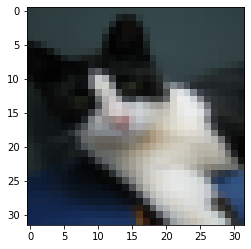

In [7]:
sample = next(image_generator)
assert sample.shape == (BATCH_SIZE, 32, 32, 3), f"Размер батча должен быть: {(BATCH_SIZE, 32, 32, 3)}.  Получен {sample.shape}"
print("Shape test passed")
# если препроцессинг правильный, то картинка ниже имеет реалистичные цвета и matplotlib не ругается
plt.imshow((sample[0] + 1.) / 2)
plt.show()

In [8]:
output = Path("cats")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan3 = DCGAN(image_size=32, num_channels=3, output_path=output, 
           z_dim=256, D_h_size=256, G_h_size=256)

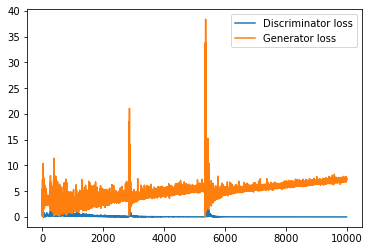

<Figure size 432x288 with 0 Axes>

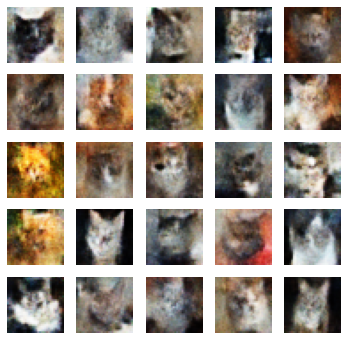


10000/10000
Time elapsed from start 11270.015437841415 sec
Finished. Time elapsed from start 11270.015456438065 sec


In [9]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan3.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan3.train(image_generator, 10000, 50)

Вектор:  [-2.2354007   1.516312    1.095759    1.0695888   0.87917066  0.410246
  0.24105504 -0.67269343 -0.9863821  -0.64854246]


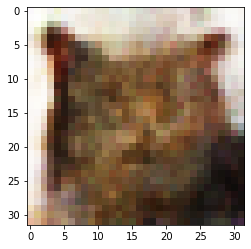

In [17]:
v1 = tf.random.normal([1, 256])                       # случайный вектор
print("Вектор: ", v1.numpy()[0, :10])                 # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan3.generator)[0])

Для улучения качества изображений с котиками следует увеличить IMAGE_SIZE до 64.